In [12]:
# -*- coding: utf-8 -*-
import warnings

warnings.filterwarnings(action='ignore')
import os, sys
import pandas as pd
import numpy as np
import math

def importOwnLib():
    if '/home/miruware/aProjects/lib' not in sys.path:
        sys.path.append('/home/miruware/aProjects/lib')
        print("lib path is successfully appended.")
    else:
        print("lib path is already exists.")

importOwnLib()
import sonyalib as sonya

import importlib
importlib.reload(sonya)

import datetime
import timeit

from scipy import interp

import keras
from keras import backend as K
from keras.optimizers import Adam
from keras import callbacks, losses
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
# import argparse
# import locale
from keras import initializers

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
# %matplotlib inline # jupyter 에서만 사용

## RFE
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold,train_test_split, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.metrics import auc, roc_curve  # plot_roc_curve


lib path is already exists.


In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True # GPU메모리가 전부 할당되지 않고, 아주 적은 비율만 할당되어 시작해서 프로세스의 메모리 수요에 따라 증가하게 된다.
config.gpu_options.visible_device_list = "0"
K.set_session(tf.Session(config=config))


def mlp_model(num_input = 0, dropout=0, learning_rate=0.005, neuron1=9, neuron2=9):
    global num_features
    num_input = num_features
    keras.backend.clear_session()
    ## 모델 구성하기
    seed_number = 7
    model = Sequential()
    # print learning rate

    model.add(Dense(neuron1, activation='relu', input_dim=num_input, kernel_initializer=initializers.he_normal(seed=seed_number)))
    model.add(BatchNormalization())
    model.add(Dense(neuron2, activation='relu', kernel_initializer=initializers.he_normal(seed=seed_number)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.he_normal(seed=seed_number)))

    ## 모델 컴파일
    model.compile(optimizer=Adam(learning_rate), loss=losses.binary_crossentropy, metrics=['accuracy'])

    # model.summary()
    return model

def confusion_metrics(conf_matrix):
    # save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)

    # calculate accuracy
    conf_accuracy = (float(TP + TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1 - conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-' * 50)
    print(f'Accuracy: {round(conf_accuracy, 2)}')
    print(f'Mis-Classification: {round(conf_misclassification, 2)}')
    print(f'Sensitivity: {round(conf_sensitivity, 2)}')
    print(f'Specificity: {round(conf_specificity, 2)}')
    print(f'Precision: {round(conf_precision, 2)}')
    print(f'f_1 Score: {round(conf_f1, 2)}')

    return conf_sensitivity,  conf_specificity

In [14]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    nodes_increment = (last_layer_nodes - first_layer_nodes) / (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

def createmodel(n_layers, first_layer_nodes, last_layer_nodes, learning_rates ,activation_func, loss_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(1, activation=activation_func))
    model.compile(optimizer= Adam(learning_rates), loss=loss_func, metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

##Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel, verbose = False)  

In [15]:
activation_funcs = ['relu'] 
loss_funcs = ['binary_crossentropy']
param_grid = dict(n_layers=[2],
                  learning_rates = [0.1, 0.05],
                  first_layer_nodes = [9,11], 
                  last_layer_nodes = [9,11],
                  activation_func = activation_funcs,
                  loss_func = loss_funcs,
                  batch_size = [25],
                  epochs = [20])

In [28]:
# start_time = timeit.default_timer()  # 시작 시간 체크
# ==== Step 1. Load original dataset
file_path0 = './BRC_input_201116_train.xlsx'
file_path1 = './BRC_input_201116_test.xlsx'
meta_train = sonya.get_normalized_metadata(file_path0)
meta_test = sonya.get_normalized_metadata(file_path1)
PATH_model = './after_first_draft'
sonya.createFolder(PATH_model)

repeat_num = 0
best_score = 0

while best_performance < 0.9:
    
    is_lMax = False   
    exam_name = "normalized_grid_rfe_median_" + str(repeat_num)
    PATH_exam = os.path.join(PATH_model, exam_name)
    sonya.createFolder(PATH_exam)
    properties = [  # total 18
        'sex',
        'age',
        'LR',
        'cT',
        'cN',
        'cAverage',
        'cSD',
        'aAverage',
        'aSD',
        'lMax',
        'homogeneous',
        'hetero',
        'rim',
        'clustered',
        'non-mass',
        'AorCa',
        'LymAo',
        'LymCa'
    ]
    num_properties = len(properties)
    
    for nf in range(num_properties):
        num_features = len(properties)
        target_dir = os.path.join(PATH_exam,'base_mode_RFE_test00_PR{}'.format(num_features))
        sonya.createFolder(target_dir)

        ## ========== get the new dataset of selected features ==========
        X_train = meta_train[properties]
        y_train = meta_train['label']

        X_test = meta_test[properties]
        y_test = meta_test['label']

        num_features = len(properties)  # update
        print('\033[31m \033[43m' + 'Current num of properties: ' + str(num_features) + '\033[0m')
        ## ========== >>>>>>>>>> optimize_hyperparameters <<<<<<<<<< ==========

        # ------------------------------------------------------------------
        '--------------------- grid search --------------------------- '
        # ==================================================================
        grid_result = GridSearchCV(estimator=model, param_grid=param_grid)
        grid_result.fit(X_train, y_train)

        best_lr = grid_result.best_params_.get('learning_rates')
        best_batch = grid_result.best_params_.get('batch_size')
        best_l1 = grid_result.best_params_.get('first_layer_nodes')
        best_l2 = grid_result.best_params_.get('last_layer_nodes')

        with open(os.path.join(PATH_exam , "param_records.txt"), "a") as file:
                param_records = "PR{}\tlr: {}\tbatch: {}\tl1: {}\tl2: {}".format(str(num_features) ,str(best_lr), str(best_batch), str(best_l1), str(best_l2))
                file.write(param_records + "\n")

        best_model = mlp_model(num_input=num_features, learning_rate= best_lr, neuron1=best_l1, neuron2=best_l2)

        kfold = StratifiedKFold(n_splits=10, shuffle=True)

        accuracy = []
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        print(properties)
        # K-fold cross validation
        # 학습 데이터를 이용해서 학습
        # ------------------------------------------------------------------
        '--------------------- cross validation --------------------------- '
        # ==================================================================
        i = 1
        for train_index, validation_index in kfold.split(X_train,y_train):
            kX_train, kX_test = X_train.iloc[train_index], X_train.iloc[validation_index]
            ky_train, ky_test = y_train.iloc[train_index], y_train.iloc[validation_index]

            cbks = [callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 2)),
                    callbacks.TensorBoard(write_graph=False)]


            best_model.fit(kX_train, ky_train, epochs=500, batch_size=best_batch, validation_data=(kX_test, ky_test),
                         callbacks=cbks, verbose=0)
            y_val_cat_prob = best_model.predict_proba(kX_test)

            k_accuracy = '%.4f' % (best_model.evaluate(kX_test, ky_test)[1])
            accuracy.append(k_accuracy)

            # roc curve
            fpr, tpr, t = roc_curve(y_train.iloc[validation_index], y_val_cat_prob)
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            model_fold_name = target_dir + '/'+ str(i) + '_AUC' +str(int(float(roc_auc) * 100)) + "_" + current_time
            model_fold_json = best_model.to_json()

        # ------------------------------------------------------------------
        '--------------------- save model --------------------------- '
        # ==================================================================
            with open('{}.json'.format(model_fold_name), 'w') as json_file:
                json_file.write(model_fold_json)  # save model per fold

            best_model.save_weights('{}.h5'.format(model_fold_name))  # save weight per fold

            i = i + 1

        
        with open(os.path.join(PATH_exam, "auc_records.txt"), "a") as file:
            auc_records = "PR{}_aucs = ".format(str(num_features)) + str(aucs)
            file.write(auc_records + "\n")

        # if the number of remained feature is 1, just save records (no rfe)
        if num_features == 1: # input 개수가 1 일경우 rfe 진행 x
            print(properties)
            with open(os.path.join(PATH_exam, "eliminated_features.txt"), "a") as file:
                file.write("{}\t{}\n".format(nf, set(properties)))
            break

        # -------------------------------- rfe --------------------------------------
        '--------------------- rfe --------------------------- '
        # ==================================================================

        from scipy.stats import zscore

        raw_data = X_train
        X_total = raw_data

        data_columns_size = X_train.columns.size

        numvars =  X_train.shape[1]

        x_sens_base = X_train.median()  # Column별 median
        x_sens_base2 = X_train.mean()  # Column별 median
        for seq_id in range(numvars):
            if len(X_train.iloc[:, seq_id].unique()) == 2:
                x_sens_base[seq_id] = 0  # Binary var는 0으로

        Sens_test_num = 10
        Pred_rx1 = np.zeros((Sens_test_num, len(x_sens_base)))  # 변수별 Sens_test결과 array
        # Pred_rx1 = pd.DataFrame()
        Pred_diff_stage = []

        min(X_train.iloc[:, 1])
        max(X_train.iloc[:, 1])

        X_train = np.array(X_train)

       # ------------------------------------------------------------------
        '--------------------- load model --------------------------- '
        # ==================================================================
        import os

        def list_files_subdir(destpath, ext):
            filelist = []
            for path, subdirs, files in os.walk(destpath):
                for filename in files:
                    f = os.path.join(path, filename)
                    if os.path.isfile(f):
                        if filename.endswith(ext):
                            filelist.append(f)
            filelist.sort()
            return filelist

        h5_list = list_files_subdir(target_dir, 'h5')
        json_list = list_files_subdir(target_dir, 'json')
        # -------------------------------------------------------

        index_list = []
        value_list = []


        df_effect = pd.DataFrame(raw_data.columns)

        for i in range(len(h5_list)):
            index_list = []
            value_list = []
            print(h5_list[i])
            print(json_list[i])
            # load model & weights
            json_name = (json_list[i])
            json_file = open(json_name, "r")
            loaded_model_json = json_file.read()
            json_file.close()
            loaded_model = model_from_json(loaded_model_json)

            h5_file = h5_list[i]
            loaded_model.load_weights(h5_file)
#             print("Loaded model from disk", h5_file, ".json/h5")
            '--------------------- end of load model --------------------------- '
            sigma = 2
            for seq_id in range(numvars):
                # for seq_id in range(1):
                X_sens_test = np.tile(x_sens_base, (Sens_test_num, 1))  # Make test base
                if (len(np.unique(X_train[:, seq_id])) == 2):
                    X_sens_test[(Sens_test_num // 2):, seq_id] = 1
                else:
                    if sigma == -1:
                        X_sens_test[:, seq_id] = np.linspace(min(X_train[:, seq_id]),
                                                             max(X_train[:, seq_id]), Sens_test_num)
                    elif sigma > 0:
                        x_avg = X_train[:, seq_id].mean();
                        x_sd = X_train[:, seq_id].std()
                        X_sens_test[:, seq_id] = np.linspace(x_avg - (sigma * x_sd), x_avg + (sigma * x_sd),
                                                             Sens_test_num)
                loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
                y_pred = loaded_model.predict_proba(X_sens_test)
                # Pred_rx1.iloc[:, seq_id] = y_pred     # class를 기준으로 함
                Pred_rx1[:, seq_id] = y_pred[:, 0]  # '0' for sigmoid, '1' for softmax # class를 기준으로 함
                # y_pred_softmax = resto_sess.run(tf.nn.softmax(y_pred))    # Pred_rx0[:, seq_id] = y_pred_softmax[:, 0]
                Pred_diff = np.max(Pred_rx1[:, seq_id], axis=0) - np.min(Pred_rx1[:, seq_id], axis=0)
                Pred_diff_stage.append(Pred_diff)
#                 print(Pred_diff)
            print("------------------------")
            df_effect[1 + i] = Pred_diff_stage
            Pred_diff_stage = []

        # ------------------------------------------------------------------
        '--------------------- feature elimination --------------------------- '
        # ==================================================================
        df_effect[1 + numvars] = df_effect.mean(axis=1)
        df_effect[2 + numvars] = df_effect.std(axis=1)
        df_effect = df_effect.rename(columns={1 + numvars: 'mean'})
        df_effect = df_effect.rename(columns={2 + numvars: 'std'})
        df_effect1 = df_effect.sort_values(by=['mean'], axis=0)
        df_effect1['fNum'] = df_effect1.index
        df_effect1 = df_effect1.reset_index(drop=True)
        df_effect0 = df_effect1
        df_effect1 = df_effect1.filter([0, 'fNum', 'mean', 'std'])
        df_effect2 = df_effect1.filter([0, 'fNum', 'mean'])

        df_effect0.to_csv(target_dir + "/rfe" + '.txt')

        elim_idx, elim_pred_diff = min(enumerate(df_effect['mean']), key=lambda x: x[1])

        elim_fName = X_total.columns[elim_idx]
        print("Elim target : ", "#", elim_idx, " ", elim_fName, "w/ effect of ", elim_pred_diff)
#         print(df_effect2)


        # ------------------------------------------------------------------
        '--------------------- end of rfe --------------------------- '
        # ==================================================================
        
        
        with open(os.path.join(PATH_model, "eliminated_features.txt"), "a") as file:
            file.write("{}\t{}\n".format(nf, elim_fName)
                       
        print(properties)
        properties.remove(elim_fName)

        # ------------------------------------------------------------------
        '--------------------- load aucs and rfe records --------------------------- '
        # ==================================================================            
                       
        aucs_txt_path = os.path.join(PATH_exam, "auc_records.txt")
        aucs_list = []
        with open(aucs_txt_path, "r") as file:
            while True:
                inLine = file.readline()
                if inLine == "":
                    break
                aucs = inLine.split(" = ")[1].strip("\n][").split(', ')
                for index, item in enumerate(aucs):
                    aucs[index] = float(item)
                aucs_list.append(aucs)

        features_txt_path = os.path.join(PATH_exam, "eliminated_features.txt")
        features_list = []
        with open(features_txt_path, "r") as file:
            while True:
                inLine = file.readline()
                if inLine == "":
                    break
                features_list.append(inLine.split('\t')[1].strip())
         # ------------------------------------------------------------------
        '--------------------- draw graph --------------------------- '
        # ==================================================================            
       
        boxprops = dict(facecolor='white')
        medianprops = dict(linewidth = 0)
        meanlineprops = dict(linestyle='-', linewidth=1)
        plt.figure(figsize=(6,4), dpi=150)
        bp = plt.boxplot(aucs_list, patch_artist=True, showfliers=False, meanline = True, showmeans=True, boxprops=boxprops, meanprops=meanlineprops, medianprops=medianprops)
        # plt.title('Box plot of aucs')
        plt.ylabel('AUROC')
        plt.xlabel('Eliminated Feature at each step of RFE')
        plt.ylim(0, 1.0)
        plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], features_list, rotation=90)

        list_mean = []
        for aucs in aucs_list:
            list_mean.append(np.mean(aucs))

        best_num = np.argmax(list_mean)
        best_performance = list_mean[best_num]
        for i, box in enumerate(bp["means"]):
            if i == best_num:
                box.set(color='red')

        plt.savefig(os.path.join(PATH_exam, './RFE_result_feature_name.png'), bbox_inches='tight')
        # plt.show()                                        
                       
        repeat_num += 1


SyntaxError: invalid syntax (<ipython-input-28-5ffbc31104b7>, line 262)

In [62]:
y_pred_proba = (best_model.predict(X_train) >= 0.693).astype(int)
cm = confusion_matrix(y_train, y_pred_proba)
print("Radiologist + AI")
print(cm)
confusion_metrics(cm)

Radiologist + AI
[[44 15]
 [39 98]]
True Positives: 98
True Negatives: 44
False Positives: 15
False Negatives: 39
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.72
Specificity: 0.75
Precision: 0.75
f_1 Score: 0.73


(0.7153284671532847, 0.7457627118644068)

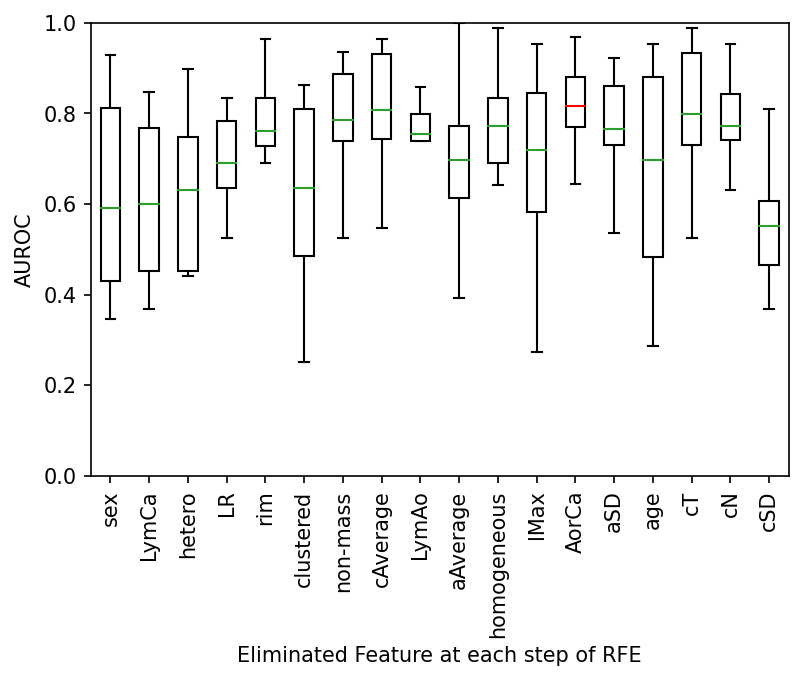

In [11]:
PATH_exam = '.'

aucs_txt_path = os.path.join(PATH_exam, "auc_records.txt")
aucs_list = []
with open(aucs_txt_path, "r") as file:
    while True:
        inLine = file.readline()
        if inLine == "":
            break
        aucs = inLine.split(" = ")[1].strip("\n][").split(', ')
        for index, item in enumerate(aucs):
            aucs[index] = float(item)
        aucs_list.append(aucs)

features_txt_path = os.path.join(PATH_exam, "eliminated_features.txt")
features_list = []
with open(features_txt_path, "r") as file:
    while True:
        inLine = file.readline()
        if inLine == "":
            break
        features_list.append(inLine.split('\t')[1].strip())

boxprops = dict(facecolor='white')
medianprops = dict(linewidth = 0)
meanlineprops = dict(linestyle='-', linewidth=1)
plt.figure(figsize=(6,4), dpi=150)
bp = plt.boxplot(aucs_list, patch_artist=True, showfliers=False, meanline = True, showmeans=True, boxprops=boxprops, meanprops=meanlineprops, medianprops=medianprops)
# plt.title('Box plot of aucs')
plt.ylabel('AUROC')
plt.xlabel('Eliminated Feature at each step of RFE')
plt.ylim(0, 1.0)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], features_list, rotation=90)

list_mean = []
for aucs in aucs_list:
    list_mean.append(np.mean(aucs))
    
best_num = np.argmax(list_mean)

for i, box in enumerate(bp["means"]):
    if i == best_num:
        box.set(color='red')

plt.savefig(os.path.join(PATH_exam, './RFE_result_feature_name.png'), bbox_inches='tight')
# plt.show()               

In [16]:
list_mean[best_num]

0.8156043956043956

In [24]:
properties.remove('sex')

In [34]:
properties = [  # total 18
        'sex',
        'age',
        'LR',
        'cT',
        'cN',
        'cAverage',
        'cSD',
        'aAverage',
        'aSD',
        'lMax',
        'homogeneous',
        'hetero',
        'rim',
        'clustered',
        'non-mass',
        'AorCa',
        'LymAo',
        'LymCa'
    ]

In [45]:
file_path0 = './BRC_input_201116_train.xlsx'
file_path1 = './BRC_input_201116_test.xlsx'
meta_train = sonya.get_normalized_metadata(file_path0)
meta_test = sonya.get_normalized_metadata(file_path1)

X_train = meta_train[properties]
y_train = meta_train['label']
target_dir = './after_first_draft/normalized_grid_rfe_median_3'

from scipy.stats import zscore

raw_data = X_train
X_total = raw_data

data_columns_size = X_train.columns.size

numvars =  X_train.shape[1]

x_sens_base = X_train.median()  # Column별 median
x_sens_base2 = X_train.mean()  # Column별 median
for seq_id in range(numvars):
    if len(X_train.iloc[:, seq_id].unique()) == 2:
        x_sens_base[seq_id] = 0  # Binary var는 0으로

Sens_test_num = 10
Pred_rx1 = np.zeros((Sens_test_num, len(x_sens_base)))  # 변수별 Sens_test결과 array
# Pred_rx1 = pd.DataFrame()
Pred_diff_stage = []

min(X_train.iloc[:, 1])
max(X_train.iloc[:, 1])

X_train = np.array(X_train)

# ------------------------------------------------------------------
'--------------------- load model --------------------------- '
# ==================================================================
import os

def list_files_subdir(destpath, ext):
    filelist = []
    for path, subdirs, files in os.walk(destpath):
        for filename in files:
            f = os.path.join(path, filename)
            if os.path.isfile(f):
                if filename.endswith(ext):
                    filelist.append(f)
    filelist.sort()
    return filelist
model_dir = os.path.join(target_dir, 'base_mode_RFE_test00_PR18')
h5_list = list_files_subdir(model_dir, 'h5')
json_list = list_files_subdir(model_dir, 'json')
# -------------------------------------------------------

index_list = []
value_list = []


df_effect = pd.DataFrame(raw_data.columns)

for i in range(len(h5_list)):
    index_list = []
    value_list = []
    print(h5_list[i])
    print(json_list[i])
    # load model & weights
    json_name = (json_list[i])
    json_file = open(json_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    h5_file = h5_list[i]
    loaded_model.load_weights(h5_file)
#             print("Loaded model from disk", h5_file, ".json/h5")
    '--------------------- end of load model --------------------------- '
    sigma = 2
    for seq_id in range(numvars):
        # for seq_id in range(1):
        X_sens_test = np.tile(x_sens_base, (Sens_test_num, 1))  # Make test base
        if (len(np.unique(X_train[:, seq_id])) == 2):
            X_sens_test[(Sens_test_num // 2):, seq_id] = 1
        else:
            if sigma == -1:
                X_sens_test[:, seq_id] = np.linspace(min(X_train[:, seq_id]),
                                                     max(X_train[:, seq_id]), Sens_test_num)
            elif sigma > 0:
                x_avg = X_train[:, seq_id].mean();
                x_sd = X_train[:, seq_id].std()
                X_sens_test[:, seq_id] = np.linspace(x_avg - (sigma * x_sd), x_avg + (sigma * x_sd),
                                                     Sens_test_num)
        loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
        y_pred = loaded_model.predict_proba(X_sens_test)
        # Pred_rx1.iloc[:, seq_id] = y_pred     # class를 기준으로 함
        Pred_rx1[:, seq_id] = y_pred[:, 0]  # '0' for sigmoid, '1' for softmax # class를 기준으로 함
        # y_pred_softmax = resto_sess.run(tf.nn.softmax(y_pred))    # Pred_rx0[:, seq_id] = y_pred_softmax[:, 0]
        Pred_diff = np.max(Pred_rx1[:, seq_id], axis=0) - np.min(Pred_rx1[:, seq_id], axis=0)
        Pred_diff_stage.append(Pred_diff)
#                 print(Pred_diff)
    print("------------------------")
    df_effect[1 + i] = Pred_diff_stage
    Pred_diff_stage = []

# ------------------------------------------------------------------
'--------------------- feature elimination --------------------------- '
# ==================================================================
df_effect[1 + numvars] = df_effect.mean(axis=1)
df_effect[2 + numvars] = df_effect.std(axis=1)
df_effect = df_effect.rename(columns={1 + numvars: 'mean'})
df_effect = df_effect.rename(columns={2 + numvars: 'std'})
df_effect1 = df_effect.sort_values(by=['mean'], axis=0)
df_effect1['fNum'] = df_effect1.index
df_effect1 = df_effect1.reset_index(drop=True)
df_effect0 = df_effect1
df_effect1 = df_effect1.filter([0, 'fNum', 'mean', 'std'])
df_effect2 = df_effect1.filter([0, 'fNum', 'mean'])

df_effect0.to_csv(target_dir + "/rfe" + '.txt')

elim_idx, elim_pred_diff = min(enumerate(df_effect['mean']), key=lambda x: x[1])

elim_fName = X_total.columns[elim_idx]
print("Elim target : ", "#", elim_idx, " ", elim_fName, "w/ effect of ", elim_pred_diff)
#         print(df_effect2)


# ------------------------------------------------------------------
'--------------------- end of rfe --------------------------- '
# ==================================================================


with open(os.path.join(PATH_model, "eliminated_features.txt"), "a") as file:
    file.write("{}\t{}\n".format(nf, elim_fName))

print(properties)
properties.remove(elim_fName)

# ------------------------------------------------------------------
'--------------------- load aucs and rfe records --------------------------- '
# ==================================================================            

aucs_txt_path = os.path.join(PATH_exam, "auc_records.txt")
aucs_list = []
with open(aucs_txt_path, "r") as file:
    while True:
        inLine = file.readline()
        if inLine == "":
            break
        aucs = inLine.split(" = ")[1].strip("\n][").split(', ')
        for index, item in enumerate(aucs):
            aucs[index] = float(item)
        aucs_list.append(aucs)

features_txt_path = os.path.join(PATH_exam, "eliminated_features.txt")
features_list = []
with open(features_txt_path, "r") as file:
    while True:
        inLine = file.readline()
        if inLine == "":
            break
        features_list.append(inLine.split('\t')[1].strip())
 # ------------------------------------------------------------------
'--------------------- draw graph --------------------------- '
# ==================================================================            

boxprops = dict(facecolor='white')
medianprops = dict(linewidth = 0)
meanlineprops = dict(linestyle='-', linewidth=1)
plt.figure(figsize=(6,4), dpi=150)
bp = plt.boxplot(aucs_list, patch_artist=True, showfliers=False, meanline = True, showmeans=True, boxprops=boxprops, meanprops=meanlineprops, medianprops=medianprops)
# plt.title('Box plot of aucs')
plt.ylabel('AUROC')
plt.xlabel('Eliminated Feature at each step of RFE')
plt.ylim(0, 1.0)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], features_list, rotation=90)

list_mean = []
for aucs in aucs_list:
    list_mean.append(np.mean(aucs))

best_num = np.argmax(list_mean)
best_performance = list_mean[best_num]
for i, box in enumerate(bp["means"]):
    if i == best_num:
        box.set(color='red')



./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/10_AUC93_20210702-101538.h5
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/10_AUC93_20210702-101538.json
------------------------
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/1_AUC41_20210702-101039.h5
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/1_AUC41_20210702-101039.json
------------------------
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/2_AUC59_20210702-101112.h5
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/2_AUC59_20210702-101112.json
------------------------
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/3_AUC34_20210702-101145.h5
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18/3_AUC34_20210702-101145.json
------------------------
./after_first_draft/normalized_grid_rfe_median_3/base_mode_RFE_test00_PR18

FileNotFoundError: [Errno 2] No such file or directory: './after_first_draft/normalized_grid_rfe_median_0/auc_records.txt'

In [46]:
elim_fName

'sex'

In [47]:
type(elim_fName)

str

In [48]:
properties[0]

'age'